In [8]:
import numpy as np
import torch
import pandas as pd
import time
import operator
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn import preprocessing
# from sklearn.preprocessing import StandardScaler
CONVERSION_MAP = {0:'00',1:'01',2:'02',3:'03',4:'04',5:'05',6:'06',7:'07',8:'08',9:'09'}
start_time = time.time()
research_date = range(13,31)
bitmex_maker = -0.00025
bitmex_taker = 0.00075
okex_maker = -0.0001
okex_taker = 0.0002

In [9]:
list1 = []
list2 = []
for date in research_date:
    date_str = CONVERSION_MAP[date] if date in CONVERSION_MAP else str(date)
    list1.append(pd.read_csv('/Users/dear/Desktop/Pythagoras/PC/Depth_201909'+date_str+'_btc_usd.csv',index_col ='LastUpdateId', usecols = ['BidsPrice1', 'AsksPrice1','LastUpdateId']))
    list2.append(pd.read_csv('/Users/dear/Desktop/Pythagoras/Q/Depth_201909'+date_str+'_btc_usd.csv',index_col ='LastUpdateId', usecols =['BidsPrice1', 'AsksPrice1','LastUpdateId']))

excel_file_input1 = pd.concat(list1)
excel_file_input2 = pd.concat(list2)
excel_file_input3 = pd.read_csv('/Users/dear/Desktop/Pythagoras/Funding History  2019-10-30.csv', usecols = ['symbol', 'fundingRate', 'timestamp'])

In [10]:
excel_file_input3['timestamp'] = [datetime.strptime(i,'%Y-%m-%dT%H:%M:%S.%fZ').strftime("%s") for i in excel_file_input3['timestamp']]
excel_file_input3['funding_timestamp'] = excel_file_input3['timestamp'].astype(int)
excel_file_input3['timestamp'] = excel_file_input3['timestamp'].astype(int)-8*60*60
excel_file_input3.drop(excel_file_input3[excel_file_input3['symbol'] != 'XBTUSD' ].index, inplace=True)
excel_file_input3 = excel_file_input3.drop(['symbol'], axis =1)
excel_file_input3 = excel_file_input3.set_index('timestamp')

excel_file_input1.index = (excel_file_input1.index/1000).astype(int)
excel_file_input2.index = (excel_file_input2.index/1000).astype(int)
excel_file_input1=excel_file_input1.reset_index().drop_duplicates(subset='LastUpdateId', keep='first').set_index('LastUpdateId')
excel_file_input2=excel_file_input2.reset_index().drop_duplicates(subset='LastUpdateId', keep='first').set_index('LastUpdateId')

excel_file_input1 = excel_file_input1.rename(columns={"BidsPrice1": "bid_price_bitmex", "AsksPrice1": "ask_price_bitmex"})
excel_file_input2 = excel_file_input2.rename(columns={"BidsPrice1": "bid_price_okex", "AsksPrice1": "ask_price_okex"})
excel_file_input2['contract_exp'] = (1569571200 - excel_file_input2.index)

final_input = pd.merge(excel_file_input1, excel_file_input2, left_index = True, right_index = True, how='outer')
final_input = final_input.join(excel_file_input3)

for item in final_input.columns:
    final_input[item] = final_input[item].interpolate(method='pad')
final_input['funding_exp'] = final_input['funding_timestamp']-final_input.index
final_input = final_input.drop(['funding_timestamp'], axis =1)
final_input = final_input.dropna()






In [11]:
final_input['mid_spread'] = (final_input['bid_price_okex']+final_input['ask_price_okex'])/2-(final_input['bid_price_bitmex']+final_input['ask_price_bitmex'])/2
final_input['mid_spread_ma'] = final_input['mid_spread'].rolling(window=12*60*60).mean()
final_input['mid_spread_diff'] = final_input['mid_spread']-final_input['mid_spread_ma']
final_input['mid_spread_std'] = final_input['mid_spread_diff'].rolling(window=24*60*60).std()
final_input['mid_spread_zscore'] = final_input['mid_spread_diff']/final_input['mid_spread_std']

final_input['signal'] = 0
final_input['signal'][final_input['mid_spread_zscore'] > 1] = -0.01
final_input['signal'][final_input['mid_spread_zscore'] < -1] = 0.01

final_input['position'] = 0
for i in range(2, len(final_input)):
    if final_input['mid_spread'].iloc[i] <= 0 and final_input['position'].iloc[i-1] <= 0:
        final_input['position'].iloc[i] = min(max(final_input['position'].iloc[i-1] + final_input['signal'].iloc[i],final_input['position'].iloc[i-1]),100)
    if final_input['mid_spread'].iloc[i] >= 0 and final_input['position'].iloc[i-1] >= 0:
        final_input['position'].iloc[i] = min(max(final_input['position'].iloc[i-1] + final_input['signal'].iloc[i],-100),final_input['position'].iloc[i-1])
    else:
        final_input['position'].iloc[i] = min(max(final_input['position'].iloc[i-1] + final_input['signal'].iloc[i],-100),100)
final_input['transction'] = final_input['position']-final_input['position'].shift(1)
    
    
print(final_input)



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


              bid_price_bitmex  ask_price_bitmex  bid_price_okex  \
LastUpdateId                                                       
1568376000             10332.0           10332.5        10632.68   
1568376001             10332.0           10332.5        10632.68   
1568376002             10332.0           10332.5        10632.68   
1568376003             10332.0           10332.5        10632.68   
1568376004             10332.0           10332.5        10632.68   
...                        ...               ...             ...   
1569887995              8298.0            8298.5         8356.65   
1569887996              8298.0            8298.5         8356.65   
1569887997              8298.0            8298.5         8356.65   
1569887998              8299.0            8299.5         8356.65   
1569887999              8299.0            8299.5         8356.65   

              ask_price_okex  contract_exp  fundingRate  funding_exp  \
LastUpdateId                               

In [12]:
print(final_input['transction'].abs().sum())

1939.7600000002185


In [13]:
final_input['usd_transaction'] = 0
final_input['funding_transaction'] = 0
final_input['bitmex_position'] = 0
final_input['okex_position'] = 0
final_input['usd_position'] = 0
final_input['net_worth'] = 0

final_input['bitmex_transaction'] = - final_input['transction']
final_input['okex_transaction'] = final_input['transction']
final_input['usd_transaction'][final_input['transction']>0] = (final_input['ask_price_bitmex']*(1-bitmex_maker)-final_input['ask_price_okex']*(1+okex_taker))*0.01
final_input['usd_transaction'][final_input['transction']<0] = (final_input['bid_price_okex']*(1-okex_taker)-final_input['bid_price_bitmex']*(1+bitmex_maker))*0.01
final_input['bitmex_position'] = final_input['bitmex_transaction'].rolling(min_periods=1,window=len(final_input)).sum()
final_input['okex_position'] = final_input['okex_transaction'].rolling(min_periods=1,window=len(final_input)).sum()
final_input['funding_transaction'][final_input['funding_exp']==1] = -(final_input['fundingRate'] * final_input['bitmex_position']*final_input['ask_price_bitmex'])
final_input['funding_payment'] = final_input['funding_transaction'].rolling(min_periods=1,window=len(final_input)).sum()
final_input['usd_position'] = final_input['usd_transaction'].rolling(min_periods=1,window=len(final_input)).sum()+final_input['funding_payment']
final_input['net_worth'][final_input['position']>0] = final_input['position']*(final_input['bid_price_okex']*(1-okex_taker)-final_input['bid_price_bitmex']*(1+bitmex_maker))+final_input['usd_position']+1000000
final_input['net_worth'][final_input['position']<0] = -final_input['position']*(final_input['ask_price_bitmex']*(1-bitmex_maker)-final_input['ask_price_okex']*(1+okex_taker))+final_input['usd_position']+1000000
final_input['net_worth'][final_input['position']==0] = final_input['usd_position']+1000000



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

In [15]:
final_input['net_worth'].iloc[-1]

1037424.5714923979

In [531]:
final_input['drawdown'] = (final_input['net_worth'].rolling(min_periods=1,window=len(final_input)).max()-final_input['net_worth'])/final_input['net_worth'].rolling(min_periods=1,window=len(final_input)).max()
final_input['transaction_amount'] = final_input['transction'].abs().rolling(min_periods=1,window=len(final_input)).sum()
final_input['profit_per_trade'] = (final_input['net_worth']-1000000)/final_input['transaction_amount']/final_input['ask_price_bitmex']


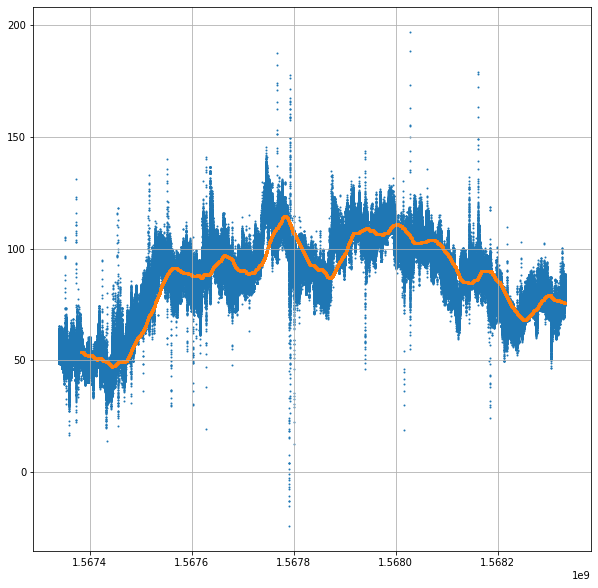

In [532]:
plt.ion()
plt.figure(figsize = (10,10))
plt.grid(True)
plt.scatter(final_input.index, final_input['mid_spread'],s=1)
plt.scatter(final_input.index, final_input['mid_spread_ma'],s=1)
plt.show()

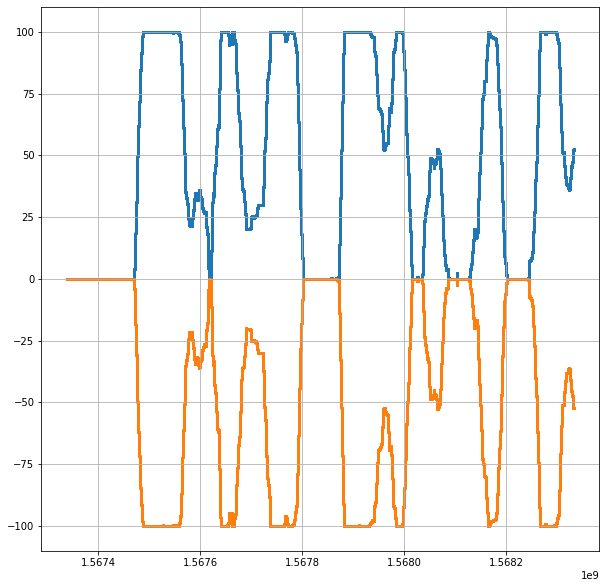

In [533]:
plt.ion()
plt.figure(figsize = (10,10))
plt.grid(True)
plt.scatter(final_input.index, final_input['bitmex_position'],s=1)
plt.scatter(final_input.index, final_input['okex_position'],s=1)
plt.show()

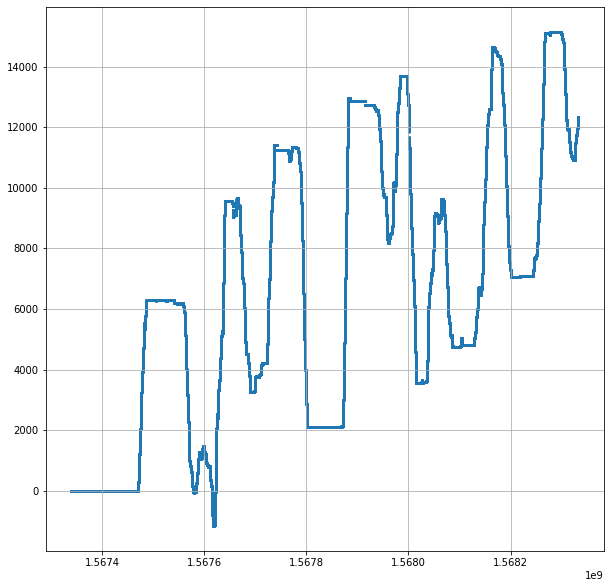

In [534]:
plt.ion()
plt.figure(figsize = (10,10))
plt.grid(True)
plt.scatter(final_input.index, final_input['usd_position'],s=1)
plt.show()

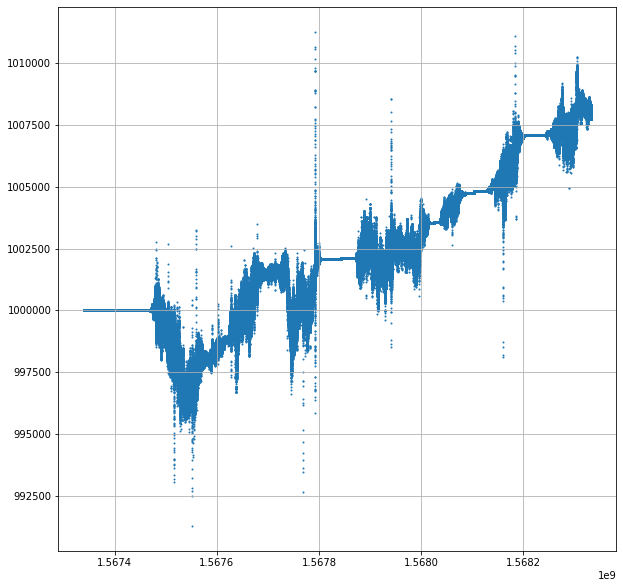

In [535]:
plt.ion()
plt.figure(figsize = (10,10))
plt.grid(True)
plt.scatter(final_input.index, final_input['net_worth'],s=1)
plt.show()

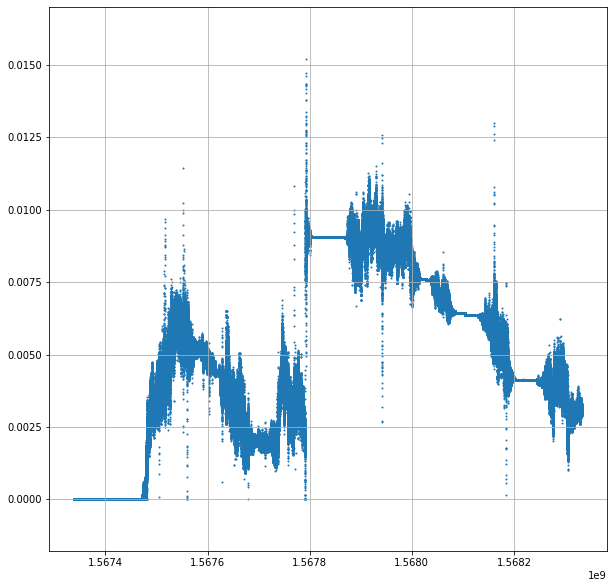

In [536]:
plt.ion()
plt.figure(figsize = (10,10))
plt.grid(True)
plt.scatter(final_input.index, final_input['drawdown'],s=1)
plt.show()

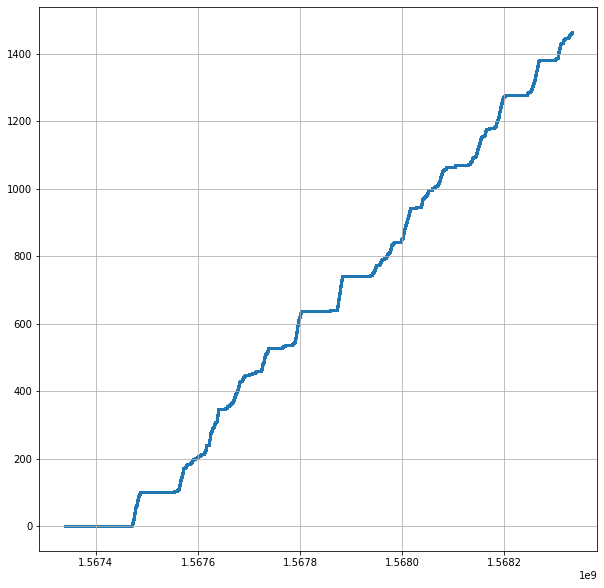

In [537]:
plt.ion()
plt.figure(figsize = (10,10))
plt.grid(True)
plt.scatter(final_input.index, final_input['transaction_amount'],s=1)
plt.show()

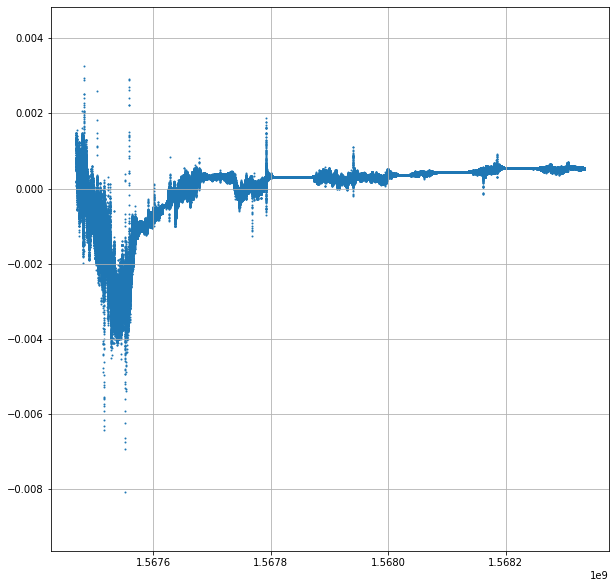

In [538]:
plt.ion()
plt.figure(figsize = (10,10))
plt.grid(True)
plt.scatter(final_input.index, final_input['profit_per_trade'],s=1)
plt.show()

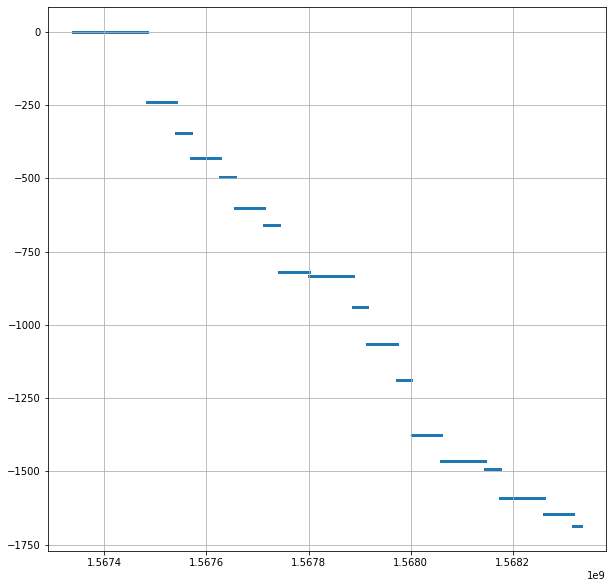

In [540]:
plt.ion()
plt.figure(figsize = (10,10))
plt.grid(True)
plt.scatter(final_input.index, final_input['funding_payment'],s=1)
plt.show()

In [539]:
print((len(final_input)-12*60*60-24*60*60)/60/60/24)

9.997511574074073


In [ ]:
data['signal -1'] = np.where((data['ask_price_bitmex'] > data['ask_price_bitmex'].shift(1)),-1,0)
data['signal +1'] = np.where((data['bid_price_bitmex'] < data['bid_price_bitmex'].shift(1)),1,0)
data['signal'] = data['signal -1'] + data['signal +1']